In [47]:
import gzip
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import Functions
from sklearn.utils.class_weight import compute_class_weight 
import pickle


In [48]:
def TS_data(ts, lag, n_ahead, target_index=-1):
    """
    A method to create X and Y matrix from a time series array for the training of Time series model
    Input:
    ts should be np.array
    lag is number of lags (timestamps back) to use for models
    n_ahead is steps ahead to forecast
    
    Output is tuple
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y


def TS_split(Final_data, lag, n_ahead):
    import random
    with gzip.open('cleaned_data.zip','rb') as data:
        data = pd.read_csv(data,index_col=[0,1])
    idlist = data.groupby('uuid').count().index

    random.seed(505)
    randid = random.sample(list(range(0,len(idlist))), len(idlist))

    train_data = pd.DataFrame()
    validation_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for i in randid[0:38]:
        train_data = pd.concat([train_data, Final_data.loc[idlist[i]]], axis = 0)
        
    for i in randid[38:45]:
        validation_data = pd.concat([validation_data, Final_data.loc[idlist[i]]], axis = 0)

    for i in randid[45:]:
        test_data = pd.concat([test_data, Final_data.loc[idlist[i]]], axis = 0)
    
    
    x_train, y_train = TS_data(train_data.values, lag, n_ahead)
    
    x_val, y_val = TS_data(validation_data.values, lag, n_ahead)
    
    x_test, y_test = TS_data(test_data.values, lag, n_ahead)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [49]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)

X_train, Y_train, X_val, Y_val, X_test, Y_test = TS_split(data, lag=3, n_ahead=1)



x_train, x_test, y_train, y_test = Functions.splitdata(data,0.1)

classes = list(range(7))
weight = compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train)
weight = dict(zip(classes,weight))

In [50]:
input_dim = X_train.shape[2]
time_step = X_train.shape[1]
units = 256
batch_size = int(len(X_train)//10000)
output_size = 7  # labels are from 0 to 6

# Build the RNN model
def build_model():
    gru_layer = keras.layers.GRU(units, input_shape=(time_step,input_dim))
    model = keras.models.Sequential(
        [
            gru_layer,
            keras.layers.Dropout(0.1),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(output_size, activation='softmax'),
        ]
    )
    return model

In [51]:
model = build_model()

#model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer="Adamax",
    metrics=["accuracy"]
)
GRU_model = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), batch_size=batch_size, epochs=50, verbose=1,class_weight=weight)

Epoch 1/50
10047/10047 [==============================] - 46s 4ms/step - loss: 1.6202 - accuracy: 0.4022 - val_loss: 2.0267 - val_accuracy: 0.2669
Epoch 2/50
10047/10047 [==============================] - 45s 4ms/step - loss: 1.3199 - accuracy: 0.5421 - val_loss: 1.4096 - val_accuracy: 0.4826
Epoch 3/50
10047/10047 [==============================] - 46s 5ms/step - loss: 0.9706 - accuracy: 0.6998 - val_loss: 1.1554 - val_accuracy: 0.5835
Epoch 4/50
10047/10047 [==============================] - 45s 4ms/step - loss: 0.8815 - accuracy: 0.7341 - val_loss: 1.3090 - val_accuracy: 0.5711
Epoch 5/50
10047/10047 [==============================] - 47s 5ms/step - loss: 0.8072 - accuracy: 0.7639 - val_loss: 0.9838 - val_accuracy: 0.6790
Epoch 6/50
10047/10047 [==============================] - 47s 5ms/step - loss: 0.7509 - accuracy: 0.7868 - val_loss: 0.9585 - val_accuracy: 0.6995
Epoch 7/50
10047/10047 [==============================] - 47s 5ms/step - loss: 0.7133 - accuracy: 0.8008 - val_loss: 0

In [52]:
model.save('./GRU_model')
with open('./GRU_model/log.txt', 'wb') as file_txt:
    pickle.dump(GRU_model.history, file_txt)

INFO:tensorflow:Assets written to: ./GRU_model\assets


INFO:tensorflow:Assets written to: ./GRU_model\assets


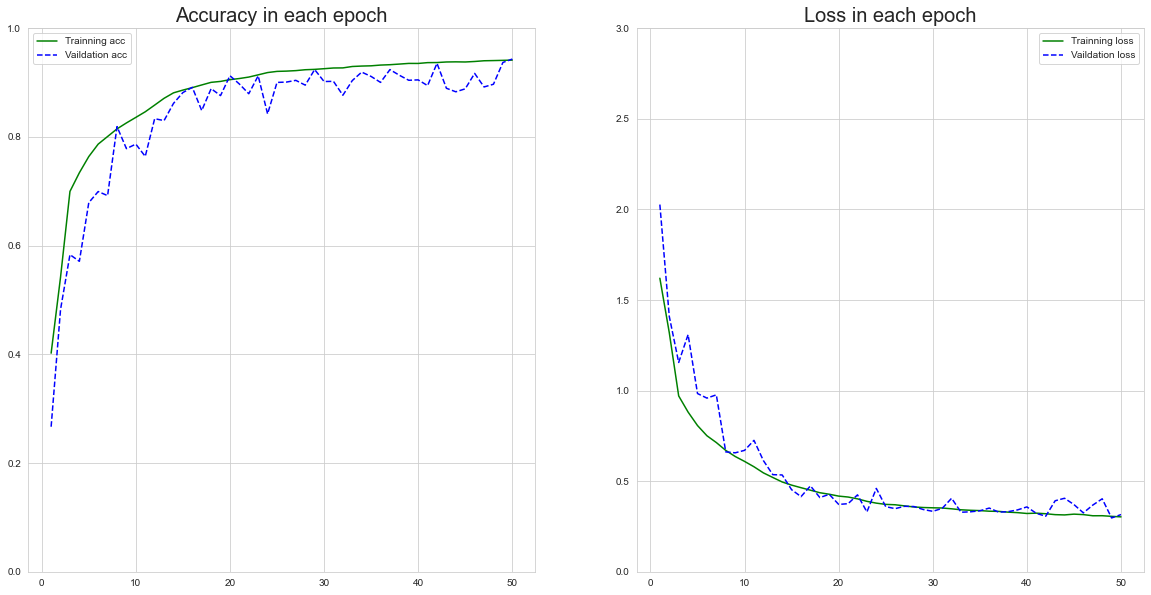

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_style("whitegrid") 

with open('./GRU_model/log.txt','rb') as file_txt:
    history=pickle.load(file_txt)

acc = history['accuracy']     #获取训练集准确性数据
val_acc = history['val_accuracy']    #获取验证集准确性数据
loss = history['loss']          #获取训练集错误值数据
val_loss = history['val_loss']  #获取验证集错误值数据

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(epochs,acc,'g',label='Trainning acc')     #以epochs为横坐标，以训练集准确性为纵坐标
ax1.plot(epochs,val_acc,'b--',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
ax1.legend()   #绘制图例，即标明图中的线段代表何种含义
ax1.set_title('Accuracy in each epoch',fontsize=20)
plt.ylim(0,1)
ax2 = fig.add_subplot(122)
ax2.plot(epochs,loss,'g',label='Trainning loss')
ax2.plot(epochs,val_loss,'b--',label='Vaildation loss')
ax2.legend()  ##绘制图例，即标明图中的线段代表何种含义
ax2.set_title('Loss in each epoch',fontsize=20)
plt.ylim(0,3)
plt.show()

1070/1070 [==============================] - 3s 3ms/step


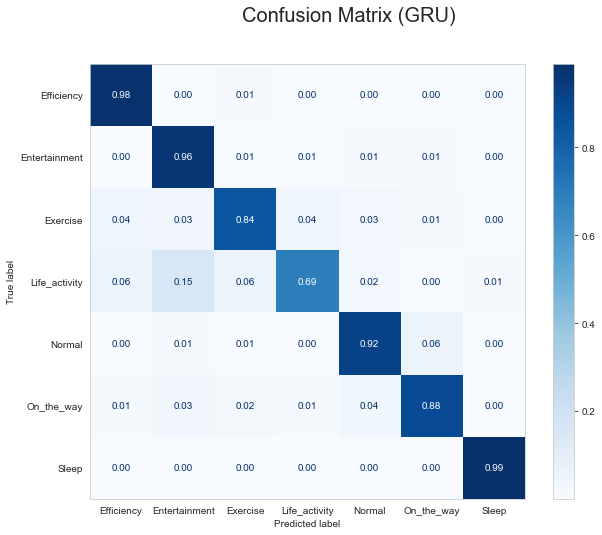

In [67]:
from sklearn import metrics

load_model = keras.models.load_model('./GRU_model')

predictions = load_model.predict(X_test)
y_test_pred = np.argmax(predictions, axis=1)

new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}
y_test_pred = [new_label_dict.get(i) for i in y_test_pred]
y_test_true = [new_label_dict.get(int(z)) for z in [j for j in [i for i in Y_test]]]


confusion = metrics.ConfusionMatrixDisplay.from_predictions(y_test_true,y_test_pred,cmap='Blues',normalize='true',values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix (GRU)",fontsize=20)
confusion.figure_.set_size_inches(10,8)
plt.grid(visible=None)
plt.show()

In [62]:
from sklearn.metrics import *
print(classification_report(y_test_true, y_test_pred))

               precision    recall  f1-score   support

   Efficiency       0.97      0.98      0.98      7937
Entertainment       0.94      0.96      0.95      5915
     Exercise       0.87      0.84      0.86      2194
Life_activity       0.77      0.69      0.73      1012
       Normal       0.97      0.92      0.94      8012
   On_the_way       0.65      0.88      0.75      1197
        Sleep       0.99      0.99      0.99      7949

     accuracy                           0.94     34216
    macro avg       0.88      0.90      0.89     34216
 weighted avg       0.95      0.94      0.95     34216

